# Human Horse Binary ConvNet Classifier

### Importing required modules

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Defining a directory

In [2]:
train_horse_dir = os.path.join('horse-or-human/horse-or-human/train/horses')
train_human_dir = os.path.join('horse-or-human/horse-or-human/train/humans')

val_horse_dir = os.path.join('horse-or-human/horse-or-human/validation/horses')
val_human_dir = os.path.join('horse-or-human/horse-or-human/validation/humans')

In [3]:
train_human_name = os.listdir(train_human_dir)
train_horse_name = os.listdir(train_horse_dir)
#printing some file names
print(train_human_name[:10], train_horse_name[:10])

val_human_name = os.listdir(val_human_dir)
val_horse_name = os.listdir(val_horse_dir)
#printing some file names
print(val_human_name[:10], val_horse_name[:10])

['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png', 'human01-05.png', 'human01-06.png', 'human01-07.png', 'human01-08.png', 'human01-09.png'] ['horse01-0.png', 'horse01-1.png', 'horse01-2.png', 'horse01-3.png', 'horse01-4.png', 'horse01-5.png', 'horse01-6.png', 'horse01-7.png', 'horse01-8.png', 'horse01-9.png']
['valhuman01-00.png', 'valhuman01-01.png', 'valhuman01-02.png', 'valhuman01-03.png', 'valhuman01-04.png', 'valhuman01-05.png', 'valhuman01-06.png', 'valhuman01-07.png', 'valhuman01-08.png', 'valhuman01-09.png'] ['horse1-000.png', 'horse1-105.png', 'horse1-122.png', 'horse1-127.png', 'horse1-170.png', 'horse1-204.png', 'horse1-224.png', 'horse1-241.png', 'horse1-264.png', 'horse1-276.png']


### Printing Number of Train and Validation Photos available in dataset

In [4]:
print('Number of Horse Photos (Train):',len(train_horse_name))
print('NUmber of Human Photos (Train):',len(train_human_name))

print('Number of Horse Photos (Validation):',len(val_horse_name))
print('NUmber of Human Photos (Validation):',len(val_human_name))

Number of Horse Photos (Train): 500
NUmber of Human Photos (Train): 527
Number of Horse Photos (Validation): 128
NUmber of Human Photos (Validation): 128


### Picking and visualizing some random images from the dataset

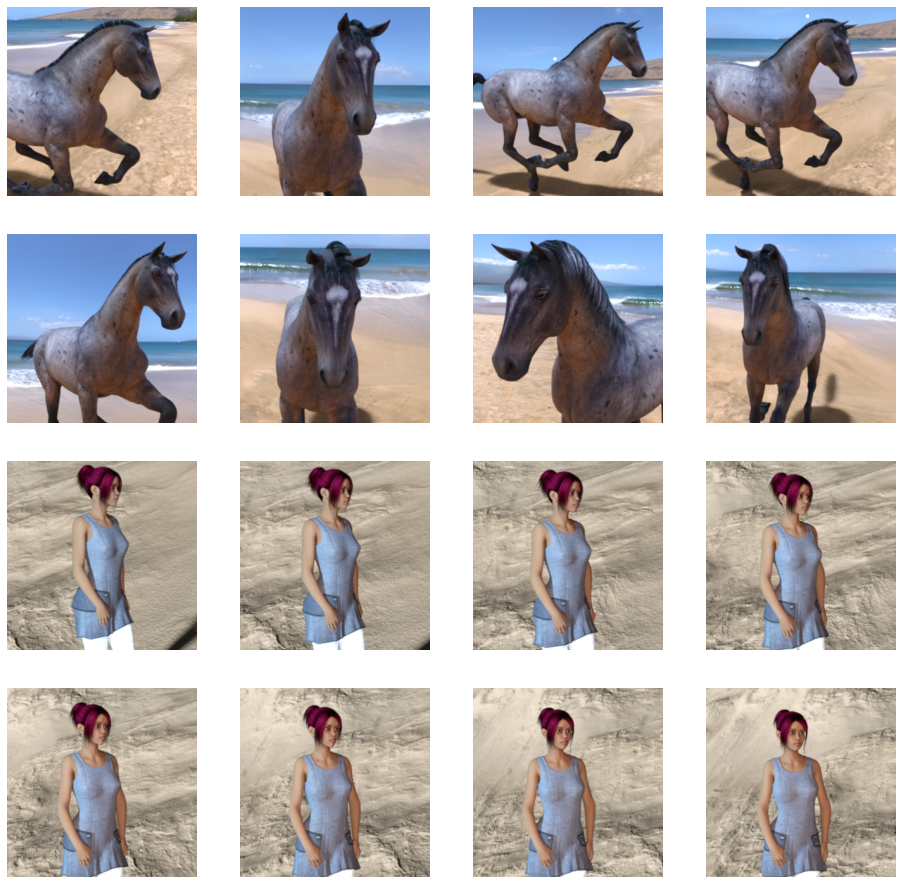

In [5]:
from random import randint

random_val = randint(0,250)
nrows = ncols = 4
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_name[8 + random_val:16 + random_val]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_name[8+random_val:16+random_val]]

%matplotlib inline

fig = plt.gcf()
fig.set_size_inches(ncols*4 , nrows * 4)

for i, img_path in enumerate(next_horse_pix + next_human_pix):
    sub_plot = plt.subplot(nrows , ncols , i+1)
    sub_plot.axis('off')
    
    plt.imshow(mpimg.imread(img_path))
    
plt.show()

## Defining Nerual Network Model and it's Layers
This Model has 3 Convolutional Layers of 3x3 Filters and 3 Max Pooling Layers after each convolution , and lastly the program has a flatten layer then a hidden layer of 512 neurons and another 1 neuron output layer

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16 , (3,3) , input_shape = (150,150,3) , activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32 , (3,3) , activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64 , (3,3) , activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512 , activation = 'relu'),
    tf.keras.layers.Dense(1 ,activation = 'sigmoid')
])

Using a RMS prop optimizer with a learning rate of 0.001 and a binary crossentropy loss

In [7]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 0.001) , loss = 'binary_crossentropy' , metrics = ['accuracy'])

## Summary of Processing of the Neural Network
A visualization of what processing will happen inside the neural network and how will each layer affect the image's properties

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

## Image Preprocessing  using keras's ImageDataGenerator
Making images of size 150x150 and passing them into the Conv Nerual Network in batches of 128 (Train) and 32(Validation)

In [9]:
training_datagen = ImageDataGenerator(rescale = 1/225.0)
val_datagen = ImageDataGenerator(rescale = 1/225.0)

training_gen = training_datagen.flow_from_directory(
'horse-or-human/horse-or-human/train',
target_size=(150,150),
batch_size=128,
class_mode='binary')

val_gen = val_datagen.flow_from_directory(
'horse-or-human/horse-or-human/validation',
target_size = (150,150),
batch_size = 32,
class_mode = 'binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


# Training the Model
Finally training the model for 15 epochs and using a callback for when the program achieves 99 % accuracy to avoid overfitting

In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<0.03):
            print("\nReached 97% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

model.fit(
training_gen,
steps_per_epoch = 8,
epochs = 15,
callbacks = callbacks,
validation_steps=8 , 
validation_data=val_gen,
)


Epoch 1/15
8/8 [==============================] - 12s 1s/step - loss: 2.6285 - accuracy: 0.5184 - val_loss: 0.5186 - val_accuracy: 0.8516
Epoch 2/15
8/8 [==============================] - 12s 1s/step - loss: 0.6324 - accuracy: 0.6852 - val_loss: 0.7159 - val_accuracy: 0.5781
Epoch 3/15
8/8 [==============================] - 11s 1s/step - loss: 0.3116 - accuracy: 0.8932 - val_loss: 0.8977 - val_accuracy: 0.7578
Epoch 4/15
8/8 [==============================] - 11s 1s/step - loss: 0.5252 - accuracy: 0.8242 - val_loss: 1.2320 - val_accuracy: 0.7383
Epoch 5/15
8/8 [==============================] - 11s 1s/step - loss: 0.1075 - accuracy: 0.9566 - val_loss: 1.6931 - val_accuracy: 0.7930
Epoch 6/15
8/8 [==============================] - 12s 1s/step - loss: 0.1008 - accuracy: 0.9588 - val_loss: 1.4853 - val_accuracy: 0.7969
Epoch 7/15
8/8 [==============================] - 13s 2s/step - loss: 1.4561 - accuracy: 0.8743 - val_loss: 1.6382 - val_accuracy: 0.7500
Epoch 8/15
8/8 [==================

## Testing the Neural Network
Testing the Neural Network by using a bunch of random horse and human images picked from the internet. The Network predicts every image correctly

In [12]:
from tensorflow.keras.preprocessing import image

for i in ['horse_test.jpg' , 'horse_test_1.jpg' , 'human_test.jpg' , 'human_test_1.jpg' , 'human_test_2.jpg']:
    img = image.load_img(i, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(i + " is a human")
    else:
        print(i + " is a horse")


[0.]
horse_test.jpg is a horse
[0.]
horse_test_1.jpg is a horse
[1.]
human_test.jpg is a human
[1.]
human_test_1.jpg is a human
[1.]
human_test_2.jpg is a human
